Resources:
- https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

In [1]:
from data_loaders import get_data_loaders
from resnet import ResNet, BottleNeckBlock

import torch
import torchvision
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

In [2]:
writer = SummaryWriter()

In [4]:
# Smaller batch size simply for visualization
train_loader, _ = get_data_loaders(batch_size=10)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# Converts tensor to correct format for matplotlib 'imshow'
def plt_imshow(image):
    # See: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/4
    inv_normalize = torchvision.transforms.Normalize(
        mean=[-0.4914, -0.4822, -0.4465],
        std=[1/0.2470, 1/0.2435, 1/0.2616]
    )
    image = inv_normalize(image)
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

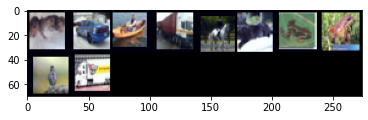

In [25]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images, normalize=True, scale_each=True)
plt_imshow(img_grid)

In [26]:
writer.add_image('some_CIFAR10_images', img_grid)

In [29]:
model = ResNet(3, 10, block_type=BottleNeckBlock, depths=[3, 4, 6, 3])

In [30]:
writer.add_graph(model, images)

In [21]:
train_loader, test_loader = get_data_loaders(batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
# Using same training code as before, but no need to print to the console, live plot is in tensorboard!
# Some hyper params
writer = SummaryWriter('./runs/lr_0.1')
base_lr = 0.1
momentum = 0.9
weight_decay = 1e-4
lr_decay = 0.1
epochs = 10
log_freq = 150

model.cuda()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=base_lr,
    momentum=momentum,
    weight_decay=weight_decay,
    nesterov=True)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[80, 120],
    gamma=lr_decay)

loss_fcn = torch.nn.CrossEntropyLoss(size_average=True)

batch_count = 0
for epoch in range(epochs):
    scheduler.step()

    for step, (data, targets) in enumerate(train_loader):
        batch_count += 1
        # Move data to gpu
        data = data.cuda()
        targets = targets.cuda()

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        # Backprop
        loss = loss_fcn(outputs, targets)
        loss.backward()
        
        # Step optimizer
        optimizer.step()

        if step % log_freq == 0:
            writer.add_scalar('training_loss', loss.item(), global_step=batch_count)

    print('Done with epoch: %s'%epoch)

Done with epoch: 0
Done with epoch: 1
Done with epoch: 2
Done with epoch: 3
Done with epoch: 4
Done with epoch: 5
Done with epoch: 6
Done with epoch: 7
Done with epoch: 8
Done with epoch: 9


In [39]:
writer.close()

In [11]:
# Crank learning rate down, train again. Using a new writer, we can plot everything together
writer = SummaryWriter('./runs/lr_0.01')
base_lr = 0.01

model = ResNet(3, 10, block_type=BottleNeckBlock, depths=[3, 4, 6, 3])
model.cuda()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=base_lr,
    momentum=momentum,
    weight_decay=weight_decay,
    nesterov=True)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[80, 120],
    gamma=lr_decay)

loss_fcn = torch.nn.CrossEntropyLoss(size_average=True)

batch_count = 0
for epoch in range(epochs):
    scheduler.step()

    for step, (data, targets) in enumerate(train_loader):
        batch_count += 1
        # Move data to gpu
        data = data.cuda()
        targets = targets.cuda()

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        # Backprop
        loss = loss_fcn(outputs, targets)
        loss.backward()
        
        # Step optimizer
        optimizer.step()

        if step % log_freq == 0:
            writer.add_scalar('training_loss', loss.item(), global_step=batch_count)

    print('Done with epoch: %s'%epoch)

Done with epoch: 0
Done with epoch: 1
Done with epoch: 2
Done with epoch: 3
Done with epoch: 4
Done with epoch: 5
Done with epoch: 6
Done with epoch: 7
Done with epoch: 8
Done with epoch: 9


In [12]:
writer.close()

In [18]:
# Crank learning rate down, train again. Using a new writer, we can plot everything together
writer = SummaryWriter('./runs/lr_0.01_adadelta')
base_lr = 0.01

model = ResNet(3, 10, block_type=BottleNeckBlock, depths=[3, 4, 6, 3])
model.cuda()

optimizer = torch.optim.Adadelta(
    model.parameters(),
    lr=base_lr,
    weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[80, 120],
    gamma=lr_decay)

loss_fcn = torch.nn.CrossEntropyLoss(size_average=True)

batch_count = 0
for epoch in range(epochs):
    scheduler.step()

    for step, (data, targets) in enumerate(train_loader):
        batch_count += 1
        # Move data to gpu
        data = data.cuda()
        targets = targets.cuda()

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        # Backprop
        loss = loss_fcn(outputs, targets)
        loss.backward()
        
        # Step optimizer
        optimizer.step()

        if step % log_freq == 0:
            writer.add_scalar('training_loss', loss.item(), global_step=batch_count)

    print('Done with epoch: %s'%epoch)

Done with epoch: 0
Done with epoch: 1
Done with epoch: 2
Done with epoch: 3
Done with epoch: 4
Done with epoch: 5
Done with epoch: 6
Done with epoch: 7
Done with epoch: 8
Done with epoch: 9


In [22]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
class_probs = []
class_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda
        output = model(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

In [24]:
test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

classes = test_loader.dataset.classes

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)